# データの探索とベンチマークの作成
このチュートリアルでは、アスペクトベース評価分析のデータセットを用いて、評価分析を行う機械学習モデルを構築します。まず評価分析に用いるデータセットを探索し、理解を深めます。次に、探索したデータセットを用いて、ベースラインとなる機械学習モデルを作成します。

では、必要なPythonモジュールをインポートしましょう。

In [1]:
import os
import json
import glob

import pandas as pd
import seaborn as sns
import matplotlib as plt
# plt.rcParams['font.family'] = 'IPAexGothic'  # japanese font

## データセットの読み込み
今回は評判分析のデータセットとして[chABSA-dataset](https://github.com/chakki-works/chABSA-dataset)を用いることにします。chABSA-datasetは企業の有価証券報告書に対して、各文に含まれるエンティティごとに評価情報を付与したデータセットです。[こちら](https://storage.googleapis.com/chakki/datasets/public/chABSA/chABSA-dataset.zip)からダウンロードして、`data`ディレクトリに展開してください。

データセットを探索して、理解を深めましょう。そのために、ダウンロードしたデータセットを読み込みます。

In [3]:
documents = []

json_files = glob.glob('../data/chABSA-dataset/*.json')
for json_file in json_files:
    with open(json_file, encoding="utf-8") as f:
        documents.append(json.load(f))
        
documents[0]

{'header': {'category17': '電機・精密',
  'category33': '精密機器',
  'doc_text': '有価証券報告書',
  'document_id': 'E01183',
  'document_name': '株式会社松風',
  'edi_id': 'E01183',
  'scale': '7',
  'security_code': '79790'},
 'sentences': [{'opinions': [{'category': 'NULL#general',
     'from': 20,
     'polarity': 'positive',
     'target': '景気',
     'to': 22},
    {'category': 'NULL#general',
     'from': 95,
     'polarity': 'neutral',
     'target': '先行き',
     'to': 98}],
   'sentence': '当連結会計年度の世界経済は、米国を中心に景気は概ね堅調に推移しましたが、英国のEU離脱問題による影響のほか、中国をはじめとする新興国経済の減速懸念や米国新政権の政策動向の不確実性など、景気の先行きは不透明な状況が続きました',
   'sentence_id': 0},
  {'opinions': [{'category': 'NULL#general',
     'from': 0,
     'polarity': 'positive',
     'target': '国内経済',
     'to': 4},
    {'category': 'NULL#general',
     'from': 10,
     'polarity': 'positive',
     'target': '企業収益',
     'to': 14},
    {'category': 'NULL#general',
     'from': 15,
     'polarity': 'positive',
     'target': '雇用',
     'to': 17},
    {'category': 'NUL

上記のコードを実行すると、ダウンロードしたデータを読み込み、そのうちの一件を表示します。一件のデータは一つの有価証券報告書を表しています。有価証券報告書を文単位に分解したものが`sentences`の中に入っています。各文には複数のエンティティが含まれています。`opinions`の中に、文内に含まれるエンティティ(`target`)、属性(`category`)、評価(`polarity`)が含まれています。**評価が文単位ではなく、エンティティ単位でついていることに注意してください。**

各項目に関する定義は[アノテーション定義書](https://github.com/chakki-works/chABSA-dataset/tree/master/annotation/doc)を御覧ください。

このチュートリアルでは各文に対してその評価を予測します。しかし、データセットでは文単位の評価はアノテーションされていません。ここでは文単位の評価を得るために、文中に含まれる各エンティティに対する評価の和が`0`より大きかったら`positive`、`0`より小さかったら`negative`となるようにデータセットを変換します。

In [4]:
def get_dataset_for_analysis(documents):
        dataset = {'label': [], 'category': [], 'sent': []}
        for d in documents:
            
            conv = {'negative': -1, 'positive': 1, 'neutral': 0}
            for sent in d['sentences']:
                sentiment = sum(conv[opinion['polarity']] for opinion in sent['opinions'])
                if sentiment == 0:  # neutral
                    continue
                dataset['label'].append(0 if sentiment < 0 else 1)
                dataset['category'].append(d['header']['category17'])
                dataset['sent'].append(sent['sentence'])
            
        dataset = pd.DataFrame(dataset, columns=['label', 'category', 'sent'])
        return dataset
    
dataset = get_dataset_for_analysis(documents)
dataset.head()

,label,category,sent
0,1,電機・精密,当連結会計年度の世界経済は、米国を中心に景気は概ね堅調に推移しましたが、英国のEU離脱問題に...
1,1,電機・精密,国内経済については、企業収益や雇用・所得環境に底堅さが見られるなど、総じて緩やかな回復基調を...
2,0,電機・精密,当歯科業界におきましては、デジタル化の進展により市場環境は大きく変化しており、世界規模で企業...
3,0,電機・精密,"しかしながら、当連結会計年度の売上高は、為替の円高による影響もあり、22,305百万円と前年..."
4,0,電機・精密,"営業利益は、減収の影響や積極的な販売活動に伴う費用負担の増加により、1,382百万円と前年同..."


上記の表に変換したデータを表示しました。ここで、`label`は文の評価を表しており、`sent`は評価対象の文を表しています。今回構築するベースラインの機械学習モデルの目標は、`sent`を入力した際にその`label`を予測することです。そのためにまず、データを探索し、データに対する理解を深めましょう。

## データセットの探索
データセットの探索では、データに対する理解を深めて、モデルの作成に役立てます。探索のためにPythonの`Seaborn`パッケージを使ってデータを可視化します。

まずは、評価別のデータ数を可視化してみましょう。

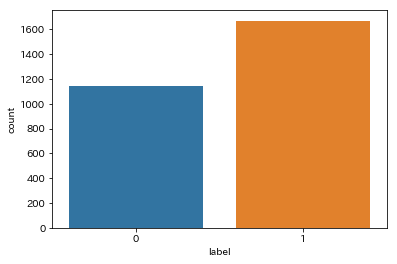

In [6]:
sns.countplot(x='label', data=dataset)

うーむ、全体的に`positive`な文が多めであるということがわかりました。

グラフをみると、`positive`な文は`negative`な文より多いことがわかります。これは、アベノミクスによる好景気が企業の業績に良い影響を与えていることや、有価証券報告書のはじめが日本の経済状況の説明から始まることが多いのが原因として考えられます。

全体的には`positive`な文が多いですが、業界別に見たらどうでしょうか？業界別に文の数と評価を可視化してみましょう。

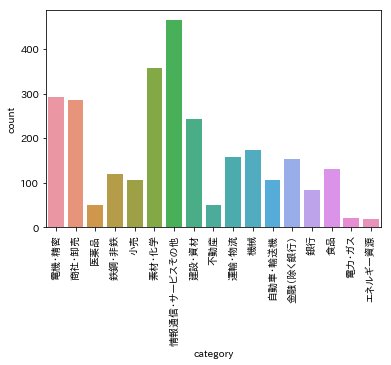

In [7]:
g = sns.countplot(x='category', data=dataset)
for item in g.get_xticklabels():
    item.set_rotation(90)

文数は業界ごとに結構差があります。そもそも、業界別の企業数が異なるのでこういう結果になるのも当然です。

では業界ごとにpositiveとnegativeの文数はどうなっているでしょうか?

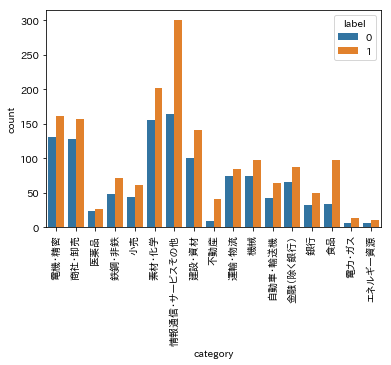

In [8]:
g = sns.countplot(x='category', hue='label', data=dataset)
for item in g.get_xticklabels():
    item.set_rotation(90)

全業界で`positive`が`negative`を上回るという結果になりました。ただ、比率は業界によって異なっています。
このような情報を利用して、業界ごとの好景気・不景気、業界間の相関(鉄鋼業界が好況だったら自動車業界も好況みたいな)を考慮したモデルを構築しても面白いかもしれませんね。

## 機械学習モデルの作成
データについての理解が深まったところで、機械学習モデルの作成に移りましょう。モデルを作成する前に、データセットを以下の3つに分割します。
* 学習用
* 検証用
* テスト用

学習用はモデルの学習に使い、検証用はハイパーパラメータチューニングに使います。テスト用はモデルの汎化性能を評価するために使います。

では、以下のようにしてデータセットを3つに分割しましょう。

In [9]:
shuffled = dataset.sample(frac=1)
trainsize = int(len(shuffled['label']) * 0.70)
validsize = int(len(shuffled['label']) * 0.15)

df_train = dataset.iloc[:trainsize, :]
df_valid = dataset.iloc[trainsize:(trainsize+validsize), :]
df_test = dataset.iloc[(trainsize+validsize):, :]

In [10]:
df_train.describe()

,label
count,1969.000000
mean,0.601320
std,0.489751
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
df_valid.describe()

,label
count,421.000000
mean,0.610451
std,0.488228
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
df_test.describe()

,label
count,423.000000
mean,0.541371
std,0.498876
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## ベンチマークの作成
複雑な機械学習モデルを作成する前に、シンプルなモデルを構築し、ベンチマークとして使いましょう。ベンチマークモデルの入力には、各文を単語列に分割し、各単語に対するTF-IDF値を計算したベクトルを使います。また、分類器にはロジスティック回帰を使います。ロジスティック回帰はシンプルながら強力なモデルであり、ベンチマークのモデルを構築する際によく使われます。評価はF1で行いましょう。

まずは、必要なPythonモジュールをインポートします。

In [13]:
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

次に入力の各文をTF-IDFのベクトルに変換します。入力文の分かち書きには形態素解析器`Janome`を使い、TF-IDFの計算には`TfidfVectorizer`を使うことにしましょう。

In [14]:
tokenizer = Tokenizer()
t = lambda text: tokenizer.tokenize(text, wakati=True)

vectorizer = TfidfVectorizer(tokenizer=t, analyzer='word')

X_train = vectorizer.fit_transform(df_train['sent'])
X_valid = vectorizer.transform(df_valid['sent'])
y_train = df_train['label']
y_valid = df_valid['label']

最後に、用意したデータを使って分類器に学習させましょう。分類器には`LogisticRegression`を使います。

In [15]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

             precision    recall  f1-score   support

          0       0.91      0.84      0.88       164
          1       0.90      0.95      0.93       257

avg / total       0.91      0.91      0.91       421



シンプルな単語ベースのモデルでは、F1で0.80という性能になりました。

これはあまり良くない性能です。どうしたら改善できるでしょうか？

原因を探ってみましょう。まずは学習曲線を書くための関数を定義します。

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return plt

学習曲線を描画すると以下のようになります。

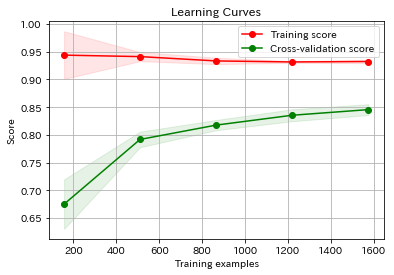

In [18]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = LogisticRegression()
plot_learning_curve(clf, title, X_train, y_train, cv=cv)

plt.show()

完全に過学習しています。原因としては、データ数に対して特徴数が大きすぎることや正則化の強さが十分でないことが考えられます。実際に特徴数を表示してみましょう。特徴数を表示するためには、`vectorizer`の`get_feature_names`メソッドを呼び出します。

In [19]:
len(vectorizer.get_feature_names())

4874

正則化については、LogisticRegressionではデフォルトではL2正則化を行っていました。しかし、結果をみると正則化しているにもかかわらず、過学習をしています。この結果は正則化の強さが十分ではないことを示唆しています。

過学習を抑えるために、正則化の強さを調整しても良いのですが、今回はL2正則化の代わりに`L1`正則化を行うことにしましょう。L1正則化をすることで、特徴選択の効果が期待できます。これは実質的には単語数を削減したモデルを作成することに相当するはずです。

In [20]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

             precision    recall  f1-score   support

          0       0.92      0.88      0.90       164
          1       0.93      0.95      0.94       257

avg / total       0.93      0.93      0.93       421



L1正則化を行うことで、性能が向上しました。では特徴選択できているのか確認してみましょう。それには、分類器の重みを確認してあげれば良さそうです。分類器の重みは、`coef_`属性の中身を見れば確認することができます。

では実際に、分類器の重みが0の個数を確認してみましょう。

In [21]:
weights = clf.coef_[0]
num_zero_weight = (weights == 0).sum()
print('{} / {}'.format(num_zero_weight, len(weights)))

4817 / 4874


結果を見ると、ほとんどの重みが0という結果になりました。では重みが0でない特徴とはどのような特徴なのでしょうか?確認してみましょう。

In [22]:
for feature, weight in zip(vectorizer.get_feature_names(), weights):
    if weight == 0:
        continue
    print('{}\t{}'.format(feature, weight))

1	0.5112467821868888
しかしながら	-1.6743482126610958
ず	-1.5043884829971665
の	-0.9654919783758908
一方	-0.0740333929910919
上回り	2.8043567275971824
上回る	1.7317813183472348
下回っ	-0.2491822333814007
下回り	-3.1126784961097727
下回る	-3.989914865011984
伴う	-1.1320869735362558
伸び悩み	-3.1151609820683492
低下	-0.41389459983708465
低調	-3.3099486864206065
低迷	-8.429917479385999
価格	-1.7019007756498916
先行き	-0.16214357697511497
利益	1.0196045141419225
前年	-0.027989905101756127
力強	-1.9598737093975211
千	-0.16480703025344268
厳しい	-6.573922414146561
向け	-0.29577278138056773
回復	5.603797402379112
堅調	6.429438821818569
増	17.761434075243123
増加	6.441448936579167
増収	5.2461354668958515
増益	3.2729352214206986
大きく	-0.7344473808176549
好調	7.899181774333481
影響	-2.254872937235749
手数料	-1.281201173732068
拡大	1.598111869888781
持ち直し	1.758890384195293
推移	2.19998163961629
損失	-2.159018468916378
改善	4.336528066667296
最高	0.9950754316752473
業務	0.7199731951280497
業界	-0.4748324898069198
活動	0.34599531099171393
減	-20.999121137091127
減収	-7.563418492401035
減少	-

以上を見ると、`増`とか`減`といった単語が分類に大きく効いてくることがわかります。

では、最後に再び学習曲線を確認してみましょう。

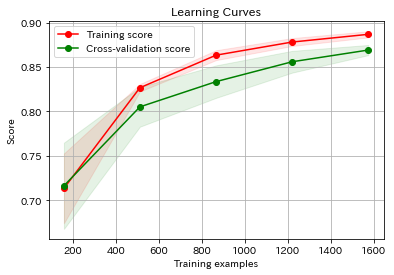

In [23]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = LogisticRegression(penalty='l1')
plot_learning_curve(clf, title, X_train, y_train, cv=cv)

plt.show()

学習と検証の性能差が縮まっていることがわかります。過学習はしていませんが、少々アンダーフィット気味です。これに対しては、正則化の強さを変化させたり、より複雑なモデルを使うといった対応をすることで性能改善します。

みなさんも、自分なりの仮説を立てて性能改善に取り組んでみましょう。